In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, Dataset, random_split
from PIL import Image
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
class WasteDataset(Dataset):
    def __init__(self, root_dirs, category, label_map, transforms=None):
        self.root_dirs = root_dirs
        self.category = category
        self.transform = transforms
        self.label_map = label_map
        self.samples = []
        for root_dir, category in zip(self.root_dirs, self.category):
            for subdir in os.scandir(root_dir):
                if subdir.is_dir():
                    label_name = subdir.name
                    label = int(self.label_map[label_name])
                    
                    for inner_subdir in os.scandir(subdir.path):
                        if inner_subdir.is_dir():
                            for file in os.scandir(inner_subdir.path):
                                if file.is_file():
                                    self.samples.append((file.path, label, category))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, category_label, waste_label = self.samples[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        category_label = torch.tensor(category_label)
        waste_label = torch.tensor(waste_label)

        return image, category_label, waste_label


In [20]:
def imshow_grid(batch, labels, categories):
    
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    for i in range(16):
        image = batch[i].permute(1, 2, 0).numpy()
        image = (image * 255).astype(np.uint8)
        label = labels[i]
        category = categories[i]

        ax = axes[i // 4, i % 4]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{label}, {category}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [21]:
label_map = {
    'coffee_grounds': 0,
    'eggshells': 1,
    'food_waste': 2,
    'tea_bags': 3,
    'glass_beverage_bottles': 4,
    'glass_cosmetic_containers': 5,
    'glass_food_jars': 6,
    'aerosol_cans': 7,
    'aluminum_food_cans': 8,
    'aluminum_soda_cans': 9,
    'steel_food_cans': 10,
    'cardboard_boxes': 11,
    'cardboard_packaging': 12,
    'magazines': 13,
    'newspaper': 14,
    'office_paper': 15,
    'paper_cups': 16,
    'disposable_plastic_cutlery': 17,
    'plastic_cup_lids': 18,
    'plastic_detergent_bottles': 19,
    'plastic_food_containers': 20,
    'plastic_shopping_bags': 21,
    'plastic_soda_bottles': 22,
    'plastic_straws': 23,
    'plastic_trash_bags': 24,
    'plastic_water_bottles': 25,
    'styrofoam_cups': 26,
    'styrofoam_food_containers': 27,
    'clothing': 28,
    'shoes': 29
}

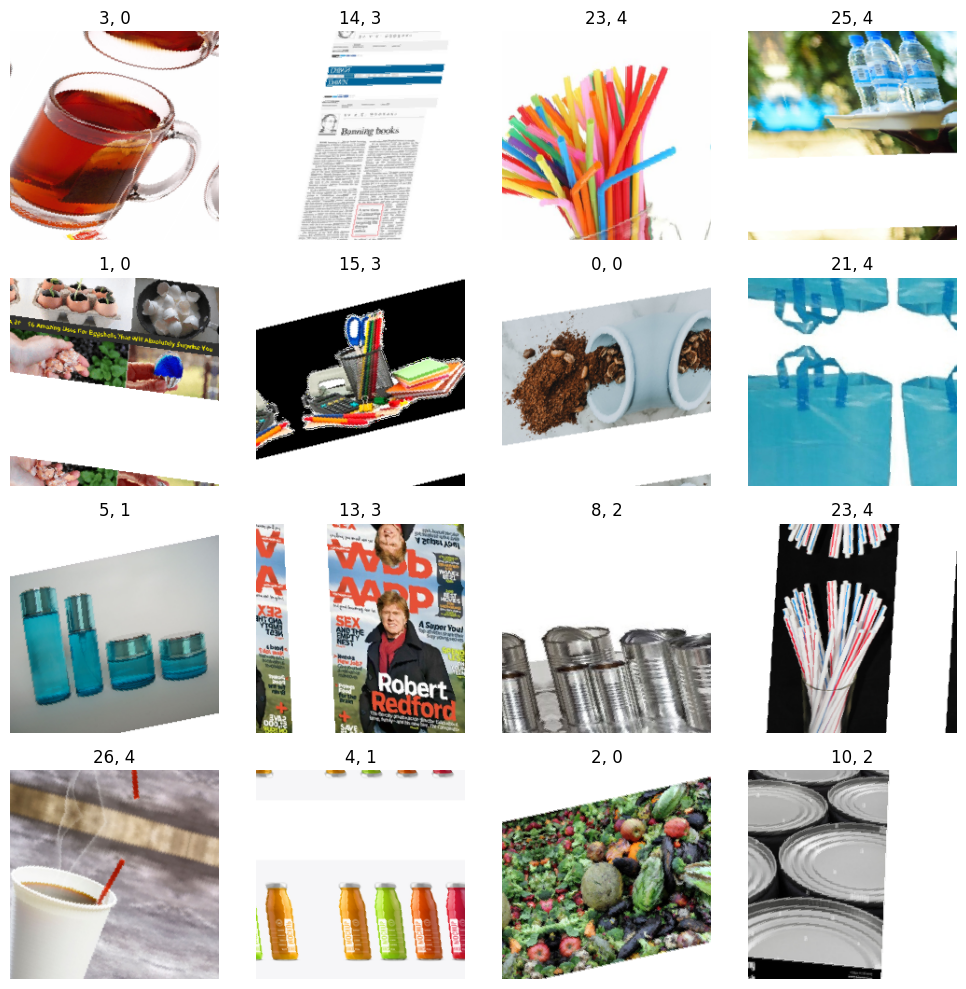

In [26]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Pad(223, padding_mode='reflect'), 
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

root_dirs = [r'C:\Users\Nickv\Documents\ImageProcessing\Project\dataset\images\Foodwaste', r'C:\Users\Nickv\Documents\ImageProcessing\Project\dataset\images\Glass', r'C:\Users\Nickv\Documents\ImageProcessing\Project\dataset\images\Metal', r'C:\Users\Nickv\Documents\ImageProcessing\Project\dataset\images\Papers', r'C:\Users\Nickv\Documents\ImageProcessing\Project\dataset\images\Plastic', r'C:\Users\Nickv\Documents\ImageProcessing\Project\dataset\images\Textile']
category = [0, 1, 2, 3, 4, 5]

dataset = WasteDataset(root_dirs=root_dirs, category=category, label_map=label_map, transforms=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

batch, label, category = next(iter(dataloader))
imshow_grid(batch, label, category)

In [27]:
class Resnet50MultiTask(nn.Module):
    def __init__(self, num_waste_classes=30, num_category_classes=6):
        super(Resnet50MultiTask, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)

        num_features = self.resnet50.fc.in_features
        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-1], nn.Flatten())
        self.waste_head = nn.Linear(num_features, num_waste_classes)
        self.category_head = nn.Linear(num_features, num_category_classes)

    def forward(self, x):
        x = self.resnet50(x)
        waste_output = self.waste_head(x)
        category_output = self.category_head(x)
        return waste_output, category_output

In [28]:
class MobileNetV3MultiTask(nn.Module):
    def __init__(self, num_waste_classes=30, num_category_classes=6):
        super(MobileNetV3MultiTask, self).__init__()
        self.mobilenet_v3 = models.mobilenet_v3_large(pretrained=True)
        
        self.features = nn.Sequential(*list(self.mobilenet_v3.children())[:-1], nn.Flatten())
        self.waste_classifier = nn.Linear(960, num_waste_classes)
        self.category_classifier = nn.Linear(960, num_category_classes)
    
    def forward(self, x):
        x = self.features(x)
        waste_output = self.waste_classifier(x)
        category_output = self.category_classifier(x)
        
        return waste_output, category_output

In [29]:
def train(model, opt, loss_fn_waste, loss_fn_category, train_loader, val_loader, epochs=10, writer=None, checkpoint_path=None, device='cuda'):
    print("🤖 Training on", device)
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        avg_train_loss = 0.0
        step = 0
        correct_train_waste = 0
        correct_train_category = 0
        total_train = 0
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        
        for images, waste_labels, category_labels in train_bar:
            images = images.to(device)
            waste_labels = waste_labels.to(device)
            category_labels = category_labels.to(device)

            waste_outputs, category_outputs = model(images)
            loss_waste = loss_fn_waste(waste_outputs, waste_labels)
            loss_category = loss_fn_category(category_outputs, category_labels)
            total_loss = loss_waste + loss_category

            opt.zero_grad()
            total_loss.backward()
            opt.step()

            avg_train_loss += total_loss.item()

            _, waste_predicted = torch.max(waste_outputs, 1)
            _, category_predicted = torch.max(category_outputs, 1)
            correct_train_waste += (waste_predicted == waste_labels).sum().item()
            correct_train_category += (category_predicted == category_labels).sum().item()
            total_train += waste_labels.size(0)
            step += 1

            train_bar.set_postfix(loss=total_loss.item())

        avg_train_loss /= step
        train_waste_accuracy = 100 * correct_train_waste / total_train
        train_category_accuracy = 100 * correct_train_category / total_train
        
        model.eval()
        avg_val_loss = 0.0
        correct_val_waste = 0
        correct_val_category = 0
        total_val = 0
        val_bar = tqdm(val_loader, desc='📄 Validation', unit='batch')
            
        with torch.no_grad():
            for images, waste_labels, category_labels in val_bar:
                images = images.to(device)
                waste_labels = waste_labels.to(device)
                category_labels = category_labels.to(device)

                waste_outputs, category_outputs = model(images)
                val_loss_waste = loss_fn_waste(waste_outputs, waste_labels)
                val_loss_category = loss_fn_category(category_outputs, category_labels)
                val_total_loss = val_loss_waste + val_loss_category

                avg_val_loss += val_total_loss.item()

                _, waste_predicted = torch.max(waste_outputs, 1)
                _, category_predicted = torch.max(category_outputs, 1)
                correct_val_waste += (waste_predicted == waste_labels).sum().item()
                correct_val_category += (category_predicted == category_labels).sum().item()
                total_val += waste_labels.size(0)

        avg_val_loss /= len(val_loader)
        val_waste_accuracy = 100 * correct_val_waste / total_val
        val_category_accuracy = 100 * correct_val_category / total_val
    
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: [Waste: {train_waste_accuracy:.4f}, Category: {train_category_accuracy:.4f}], Val Loss: {avg_val_loss:.4f}, Val Acc: [Waste: {val_waste_accuracy:.4f}, Category: {val_category_accuracy:.4f}]')

        if writer:
            writer.add_scalar('Accuracy/Train_Waste', train_waste_accuracy, epoch + 1)
            writer.add_scalar('Accuracy/Train_Category', train_category_accuracy, epoch + 1)
            writer.add_scalar('Loss/Train', avg_train_loss, epoch + 1)
            writer.add_scalar('Accuracy/Validation_Waste', val_waste_accuracy, epoch + 1)
            writer.add_scalar('Accuracy/Validation_Category', val_category_accuracy, epoch + 1)
            writer.add_scalar('Loss/Validation', avg_val_loss, epoch + 1)

        if checkpoint_path:
            torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")

    print("🏁 Training completed.")


In [69]:
def evaluate_task(y_true, y_pred, target_names, labels):
    clf_report = classification_report(y_true, y_pred, target_names=target_names, labels=labels, zero_division=1)
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    print("\nClassification Report:\n", clf_report)

    plt.figure(figsize=(30, 15))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)

    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    plt.tight_layout()
    plt.show()

In [31]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

multitaskmodel1 = Resnet50MultiTask()

dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

loss_fn_waste = nn.CrossEntropyLoss()
loss_fn_category = nn.CrossEntropyLoss()

writer = SummaryWriter(log_dir='./runs/multitask_resnet_experiment')
opt = optim.Adam(multitaskmodel1.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model=multitaskmodel1, opt=opt, loss_fn_waste=loss_fn_waste, loss_fn_category=loss_fn_category,  epochs=20, train_loader=train_loader, val_loader=val_loader, writer=writer, device='cuda', checkpoint_path="models/multitaskmodel1/model1")
writer.close()

c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖 Training on cuda


📄 Validation: 100%|██████████| 141/141 [00:26<00:00,  5.33batch/s]


Epoch [1/10], Train Loss: 4.4984, Train Acc: [Waste: 14.8571, Category: 45.6381], Val Loss: 4.2998, Val Acc: [Waste: 18.1333, Category: 49.0667]


📄 Validation: 100%|██████████| 141/141 [00:21<00:00,  6.41batch/s]


Epoch [2/10], Train Loss: 3.7732, Train Acc: [Waste: 27.5619, Category: 54.4381], Val Loss: 3.8267, Val Acc: [Waste: 28.5778, Category: 58.3111]


📄 Validation: 100%|██████████| 141/141 [00:21<00:00,  6.45batch/s]


Epoch [3/10], Train Loss: 3.3564, Train Acc: [Waste: 34.5524, Category: 59.7333], Val Loss: 5.2269, Val Acc: [Waste: 20.6222, Category: 43.1556]


📄 Validation: 100%|██████████| 141/141 [00:22<00:00,  6.33batch/s]


Epoch [4/10], Train Loss: 3.0445, Train Acc: [Waste: 40.5810, Category: 63.8190], Val Loss: 3.8112, Val Acc: [Waste: 30.2222, Category: 60.2222]


📄 Validation: 100%|██████████| 141/141 [00:22<00:00,  6.25batch/s]


Epoch [5/10], Train Loss: 2.7643, Train Acc: [Waste: 45.4571, Category: 66.8667], Val Loss: 8.0006, Val Acc: [Waste: 16.2667, Category: 37.8667]


📄 Validation: 100%|██████████| 141/141 [00:23<00:00,  6.10batch/s]


Epoch [6/10], Train Loss: 2.5699, Train Acc: [Waste: 49.4476, Category: 69.4000], Val Loss: 2.7014, Val Acc: [Waste: 47.1111, Category: 69.1556]


📄 Validation: 100%|██████████| 141/141 [00:23<00:00,  6.05batch/s]


Epoch [7/10], Train Loss: 2.3398, Train Acc: [Waste: 53.4190, Category: 72.7238], Val Loss: 12.4341, Val Acc: [Waste: 12.3111, Category: 32.4889]


📄 Validation: 100%|██████████| 141/141 [00:22<00:00,  6.18batch/s]


Epoch [8/10], Train Loss: 2.1953, Train Acc: [Waste: 55.8857, Category: 73.7333], Val Loss: 2.9299, Val Acc: [Waste: 40.8000, Category: 65.2444]


📄 Validation: 100%|██████████| 141/141 [00:23<00:00,  6.03batch/s]


Epoch [9/10], Train Loss: 2.0888, Train Acc: [Waste: 58.0190, Category: 74.9333], Val Loss: 2.7233, Val Acc: [Waste: 44.9333, Category: 72.4889]


📄 Validation: 100%|██████████| 141/141 [00:23<00:00,  5.91batch/s]


Epoch [10/10], Train Loss: 1.9296, Train Acc: [Waste: 60.6571, Category: 77.1048], Val Loss: 2.3600, Val Acc: [Waste: 54.1333, Category: 74.7111]
🏁 Training completed.


In [33]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

multitaskmodel2 = MobileNetV3MultiTask()

dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

loss_fn_waste = nn.CrossEntropyLoss()
loss_fn_category = nn.CrossEntropyLoss()

writer = SummaryWriter(log_dir='./runs/multitask_resnet_experiment')
opt = optim.Adam(multitaskmodel2.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model=multitaskmodel2, opt=opt, loss_fn_waste=loss_fn_waste, loss_fn_category=loss_fn_category,  epochs=20, train_loader=train_loader, val_loader=val_loader, writer=writer, device='cuda', checkpoint_path="models/multitaskmodel2/model2")
writer.close()

c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖 Training on cuda


📄 Validation: 100%|██████████| 141/141 [00:22<00:00,  6.25batch/s]


Epoch [1/20], Train Loss: 2.2635, Train Acc: [Waste: 55.0952, Category: 73.6762], Val Loss: 1.8275, Val Acc: [Waste: 62.0000, Category: 77.8667]


📄 Validation: 100%|██████████| 141/141 [00:21<00:00,  6.64batch/s]


Epoch [2/20], Train Loss: 1.5272, Train Acc: [Waste: 68.6286, Category: 82.1429], Val Loss: 1.6165, Val Acc: [Waste: 67.1111, Category: 81.7778]


📄 Validation: 100%|██████████| 141/141 [00:25<00:00,  5.61batch/s]


Epoch [3/20], Train Loss: 1.2992, Train Acc: [Waste: 72.6571, Category: 84.9810], Val Loss: 1.2575, Val Acc: [Waste: 73.0667, Category: 85.9111]


📄 Validation: 100%|██████████| 141/141 [00:20<00:00,  6.72batch/s]


Epoch [4/20], Train Loss: 1.1609, Train Acc: [Waste: 75.5524, Category: 86.4286], Val Loss: 1.5468, Val Acc: [Waste: 72.0000, Category: 83.0222]


📄 Validation: 100%|██████████| 141/141 [00:21<00:00,  6.55batch/s]


Epoch [5/20], Train Loss: 1.0423, Train Acc: [Waste: 77.4381, Category: 88.1524], Val Loss: 1.2001, Val Acc: [Waste: 74.4000, Category: 87.1111]


📄 Validation: 100%|██████████| 141/141 [00:22<00:00,  6.36batch/s]


Epoch [6/20], Train Loss: 0.9648, Train Acc: [Waste: 78.6286, Category: 88.8000], Val Loss: 1.7480, Val Acc: [Waste: 65.4222, Category: 78.7111]


📄 Validation: 100%|██████████| 141/141 [00:22<00:00,  6.34batch/s]


Epoch [7/20], Train Loss: 0.8679, Train Acc: [Waste: 80.4381, Category: 90.0571], Val Loss: 1.1346, Val Acc: [Waste: 77.4222, Category: 87.3778]


📄 Validation: 100%|██████████| 141/141 [00:25<00:00,  5.62batch/s]


Epoch [8/20], Train Loss: 0.8273, Train Acc: [Waste: 81.1714, Category: 90.6762], Val Loss: 1.2003, Val Acc: [Waste: 76.4889, Category: 86.8444]


📄 Validation: 100%|██████████| 141/141 [00:24<00:00,  5.86batch/s]


Epoch [9/20], Train Loss: 0.7474, Train Acc: [Waste: 82.6000, Category: 91.8762], Val Loss: 1.2182, Val Acc: [Waste: 76.6667, Category: 87.6444]


📄 Validation: 100%|██████████| 141/141 [00:25<00:00,  5.50batch/s]


Epoch [10/20], Train Loss: 0.6841, Train Acc: [Waste: 83.8857, Category: 92.5333], Val Loss: 1.2326, Val Acc: [Waste: 75.5111, Category: 88.4444]


📄 Validation: 100%|██████████| 141/141 [00:24<00:00,  5.80batch/s]


Epoch [11/20], Train Loss: 0.6900, Train Acc: [Waste: 84.0857, Category: 92.3238], Val Loss: 1.2227, Val Acc: [Waste: 76.8889, Category: 87.0667]


📄 Validation: 100%|██████████| 141/141 [00:24<00:00,  5.82batch/s]


Epoch [12/20], Train Loss: 0.6198, Train Acc: [Waste: 85.2571, Category: 93.3905], Val Loss: 1.3000, Val Acc: [Waste: 75.8222, Category: 87.1111]


📄 Validation: 100%|██████████| 141/141 [00:23<00:00,  5.89batch/s]


Epoch [13/20], Train Loss: 0.5881, Train Acc: [Waste: 85.7238, Category: 93.5143], Val Loss: 1.1561, Val Acc: [Waste: 78.0889, Category: 89.6000]


📄 Validation: 100%|██████████| 141/141 [00:23<00:00,  5.91batch/s]


Epoch [14/20], Train Loss: 0.6084, Train Acc: [Waste: 85.3905, Category: 93.3143], Val Loss: 1.5625, Val Acc: [Waste: 70.3556, Category: 83.6000]


📄 Validation: 100%|██████████| 141/141 [00:23<00:00,  5.90batch/s]


Epoch [15/20], Train Loss: 0.5559, Train Acc: [Waste: 86.8095, Category: 94.1143], Val Loss: 1.2586, Val Acc: [Waste: 75.5556, Category: 88.0889]


📄 Validation: 100%|██████████| 141/141 [00:23<00:00,  6.00batch/s]


Epoch [16/20], Train Loss: 0.5190, Train Acc: [Waste: 87.5048, Category: 94.5619], Val Loss: 1.2022, Val Acc: [Waste: 78.4444, Category: 87.7333]


📄 Validation: 100%|██████████| 141/141 [00:24<00:00,  5.83batch/s]


Epoch [17/20], Train Loss: 0.5023, Train Acc: [Waste: 87.2952, Category: 94.5429], Val Loss: 1.0497, Val Acc: [Waste: 79.1556, Category: 89.9556]


📄 Validation: 100%|██████████| 141/141 [00:23<00:00,  5.89batch/s]


Epoch [18/20], Train Loss: 0.4936, Train Acc: [Waste: 88.0381, Category: 94.8095], Val Loss: 1.2115, Val Acc: [Waste: 77.5111, Category: 87.8222]


📄 Validation: 100%|██████████| 141/141 [00:24<00:00,  5.81batch/s]


Epoch [19/20], Train Loss: 0.4716, Train Acc: [Waste: 88.3238, Category: 94.8667], Val Loss: 1.1751, Val Acc: [Waste: 78.4889, Category: 88.8000]


📄 Validation: 100%|██████████| 141/141 [00:24<00:00,  5.87batch/s]

Epoch [20/20], Train Loss: 0.4372, Train Acc: [Waste: 88.8190, Category: 95.5714], Val Loss: 1.4733, Val Acc: [Waste: 76.9778, Category: 86.7111]
🏁 Training completed.



Classification Report:
               precision    recall  f1-score   support

     Class 0       0.79      0.88      0.83        75
     Class 1       0.73      0.70      0.71        87
     Class 2       0.78      0.82      0.80        85
     Class 3       0.49      0.52      0.50        65
     Class 4       0.68      0.52      0.59        65
     Class 5       0.55      0.55      0.55        78
     Class 6       0.84      0.38      0.52        69
     Class 7       0.35      0.81      0.49        68
     Class 8       0.65      0.14      0.22        81
     Class 9       0.54      0.60      0.57        89
    Class 10       0.48      0.56      0.51        79
    Class 11       0.44      0.90      0.59        70
    Class 12       0.71      0.16      0.26        76
    Class 13       0.63      0.61      0.62        71
    Class 14       0.80      0.28      0.41        58
    Class 15       0.32      0.15      0.21        71
    Class 16       0.79      0.53      0.63        80
  

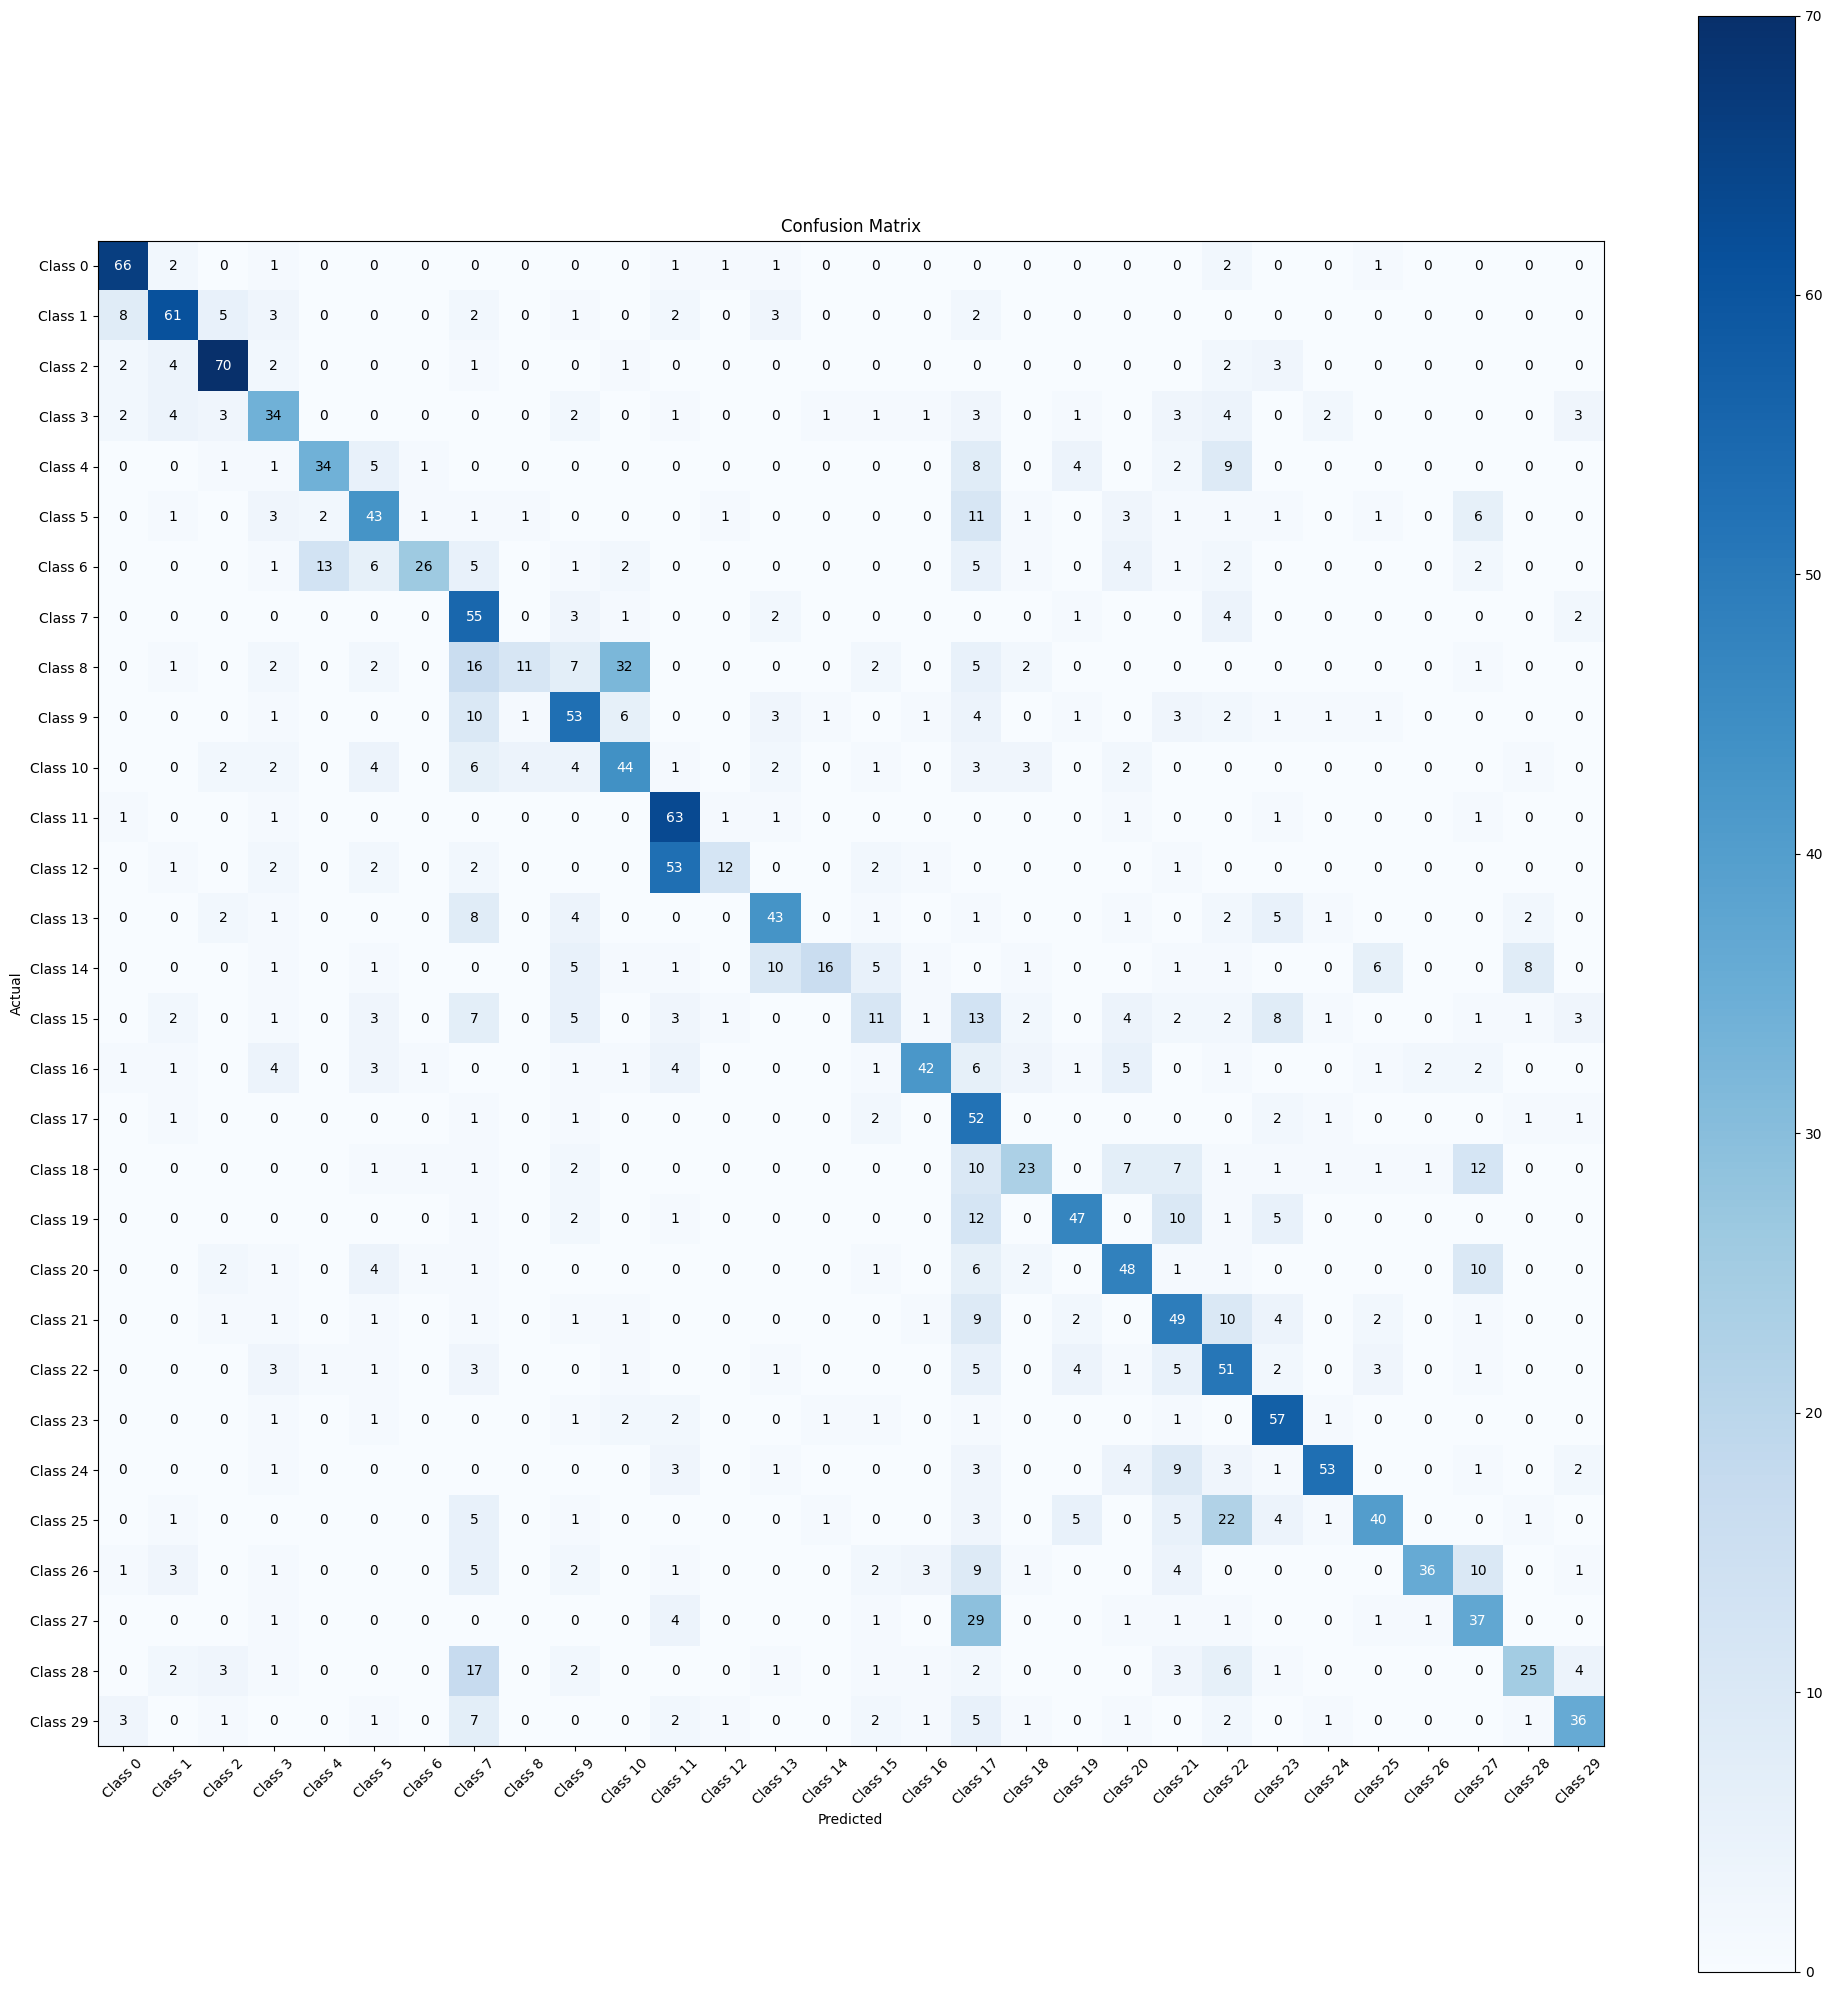


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.78      0.84      0.81       312
     Class 1       0.85      0.55      0.67       212
     Class 2       0.73      0.79      0.76       317
     Class 3       0.77      0.67      0.72       426
     Class 4       0.75      0.88      0.81       849
     Class 5       0.86      0.40      0.55       134

    accuracy                           0.76      2250
   macro avg       0.79      0.69      0.72      2250
weighted avg       0.77      0.76      0.76      2250



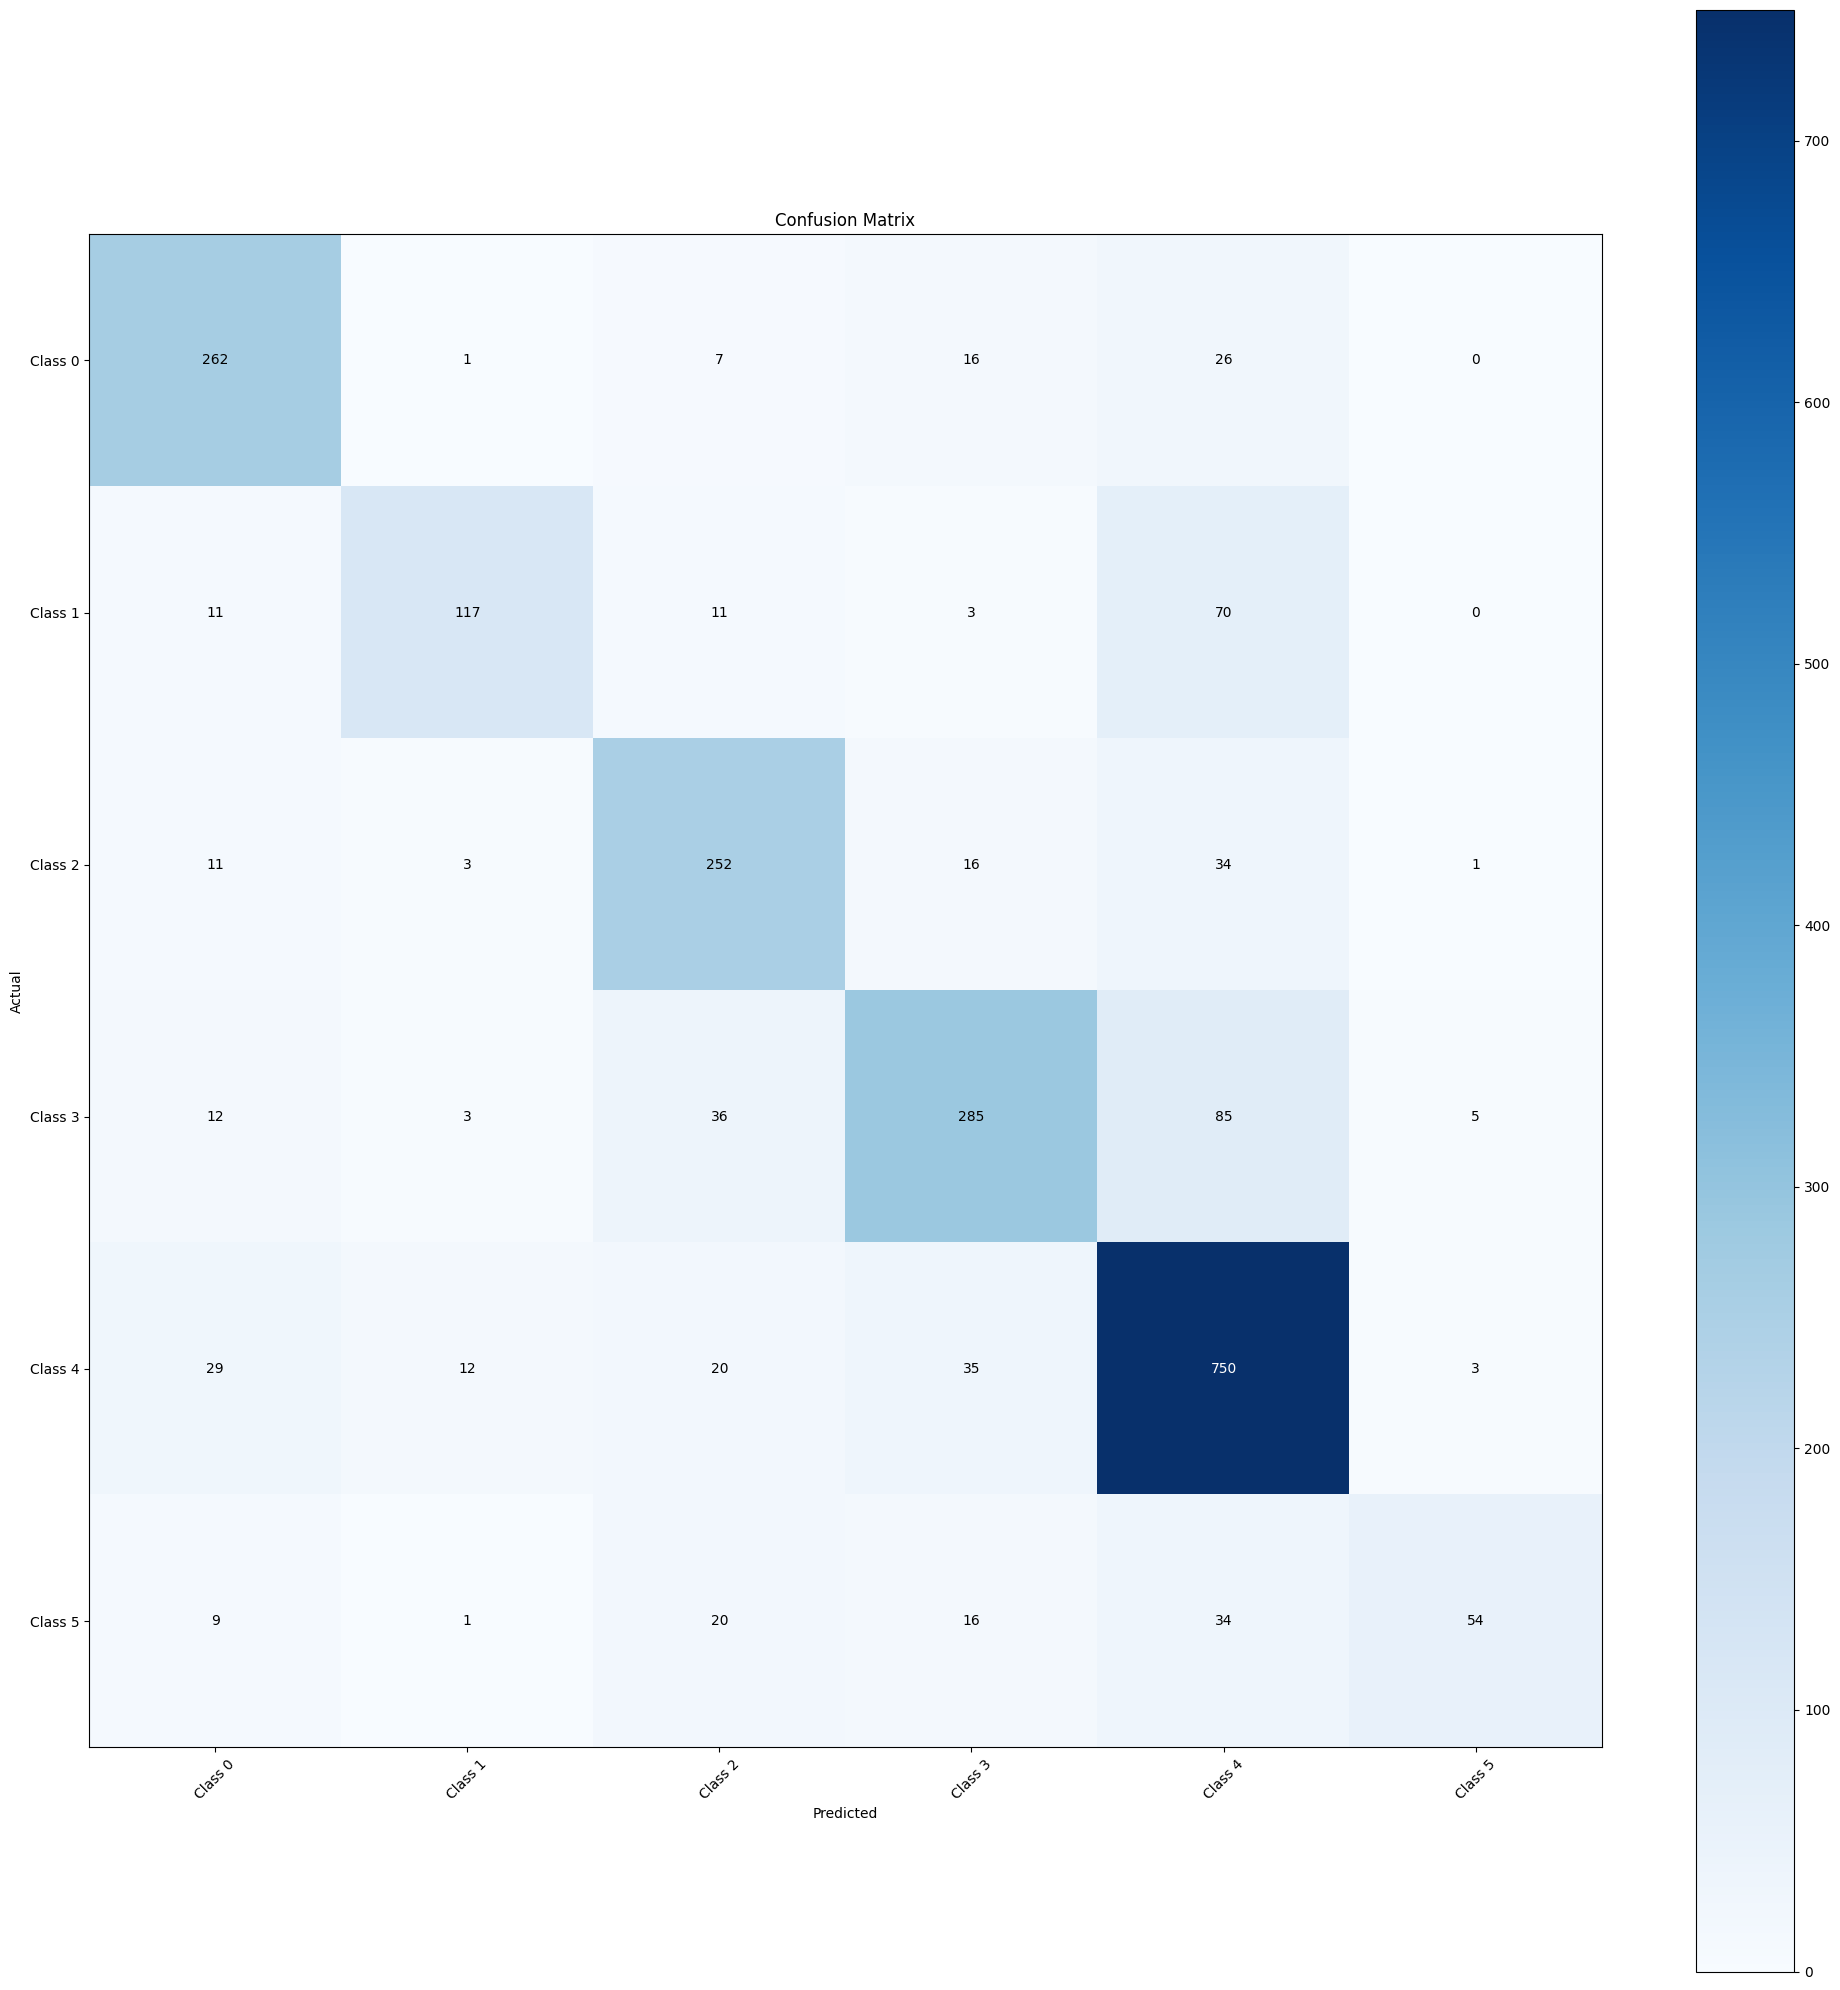

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_wastes = []
all_wastes_pred = []
all_categories = []
all_categories_pred = []
model = multitaskmodel1.to(device)

model.eval()

with torch.no_grad():
    for images, wastes, categories in test_loader:
        images = images.to(device)
        wastes = wastes.to(device)
        categories = categories.to(device)

    
        out_waste, out_category = model(images)
        _, waste_pred = torch.max(out_waste, 1)
        _, category_pred = torch.max(out_category, 1)

        all_wastes.extend(wastes.cpu().numpy())
        all_wastes_pred.extend(waste_pred.cpu().numpy())
        all_categories.extend(categories.cpu().numpy())
        all_categories_pred.extend(category_pred.cpu().numpy())

conf_matrix = confusion_matrix(all_wastes, all_wastes_pred, labels=list(range(30)))

all_wastes = np.array(all_wastes, dtype=int)
all_wastes_pred = np.array(all_wastes_pred, dtype=int)
all_categories = np.array(all_categories, dtype=int)
all_categories_pred = np.array(all_categories_pred, dtype=int)

evaluate_task(all_wastes, all_wastes_pred, target_names=list(label_map.keys()), labels=list(range(30)))
evaluate_task(all_categories, all_categories_pred, target_names=['Foodwaste', 'Glass', 'Metal', 'Papers', 'Plastic', 'Textile'], labels=list(range(6)))


Classification Report:
                             precision    recall  f1-score   support

            coffee_grounds       0.95      0.96      0.95        75
                 eggshells       0.85      0.90      0.87        87
                food_waste       0.95      0.89      0.92        85
                  tea_bags       0.75      0.68      0.71        65
    glass_beverage_bottles       0.77      0.78      0.78        65
 glass_cosmetic_containers       0.84      0.78      0.81        78
           glass_food_jars       0.82      0.87      0.85        69
              aerosol_cans       0.94      0.75      0.84        68
        aluminum_food_cans       0.62      0.64      0.63        81
        aluminum_soda_cans       0.57      0.92      0.70        89
           steel_food_cans       0.69      0.62      0.65        79
           cardboard_boxes       0.68      0.74      0.71        70
       cardboard_packaging       0.73      0.50      0.59        76
                 magaz

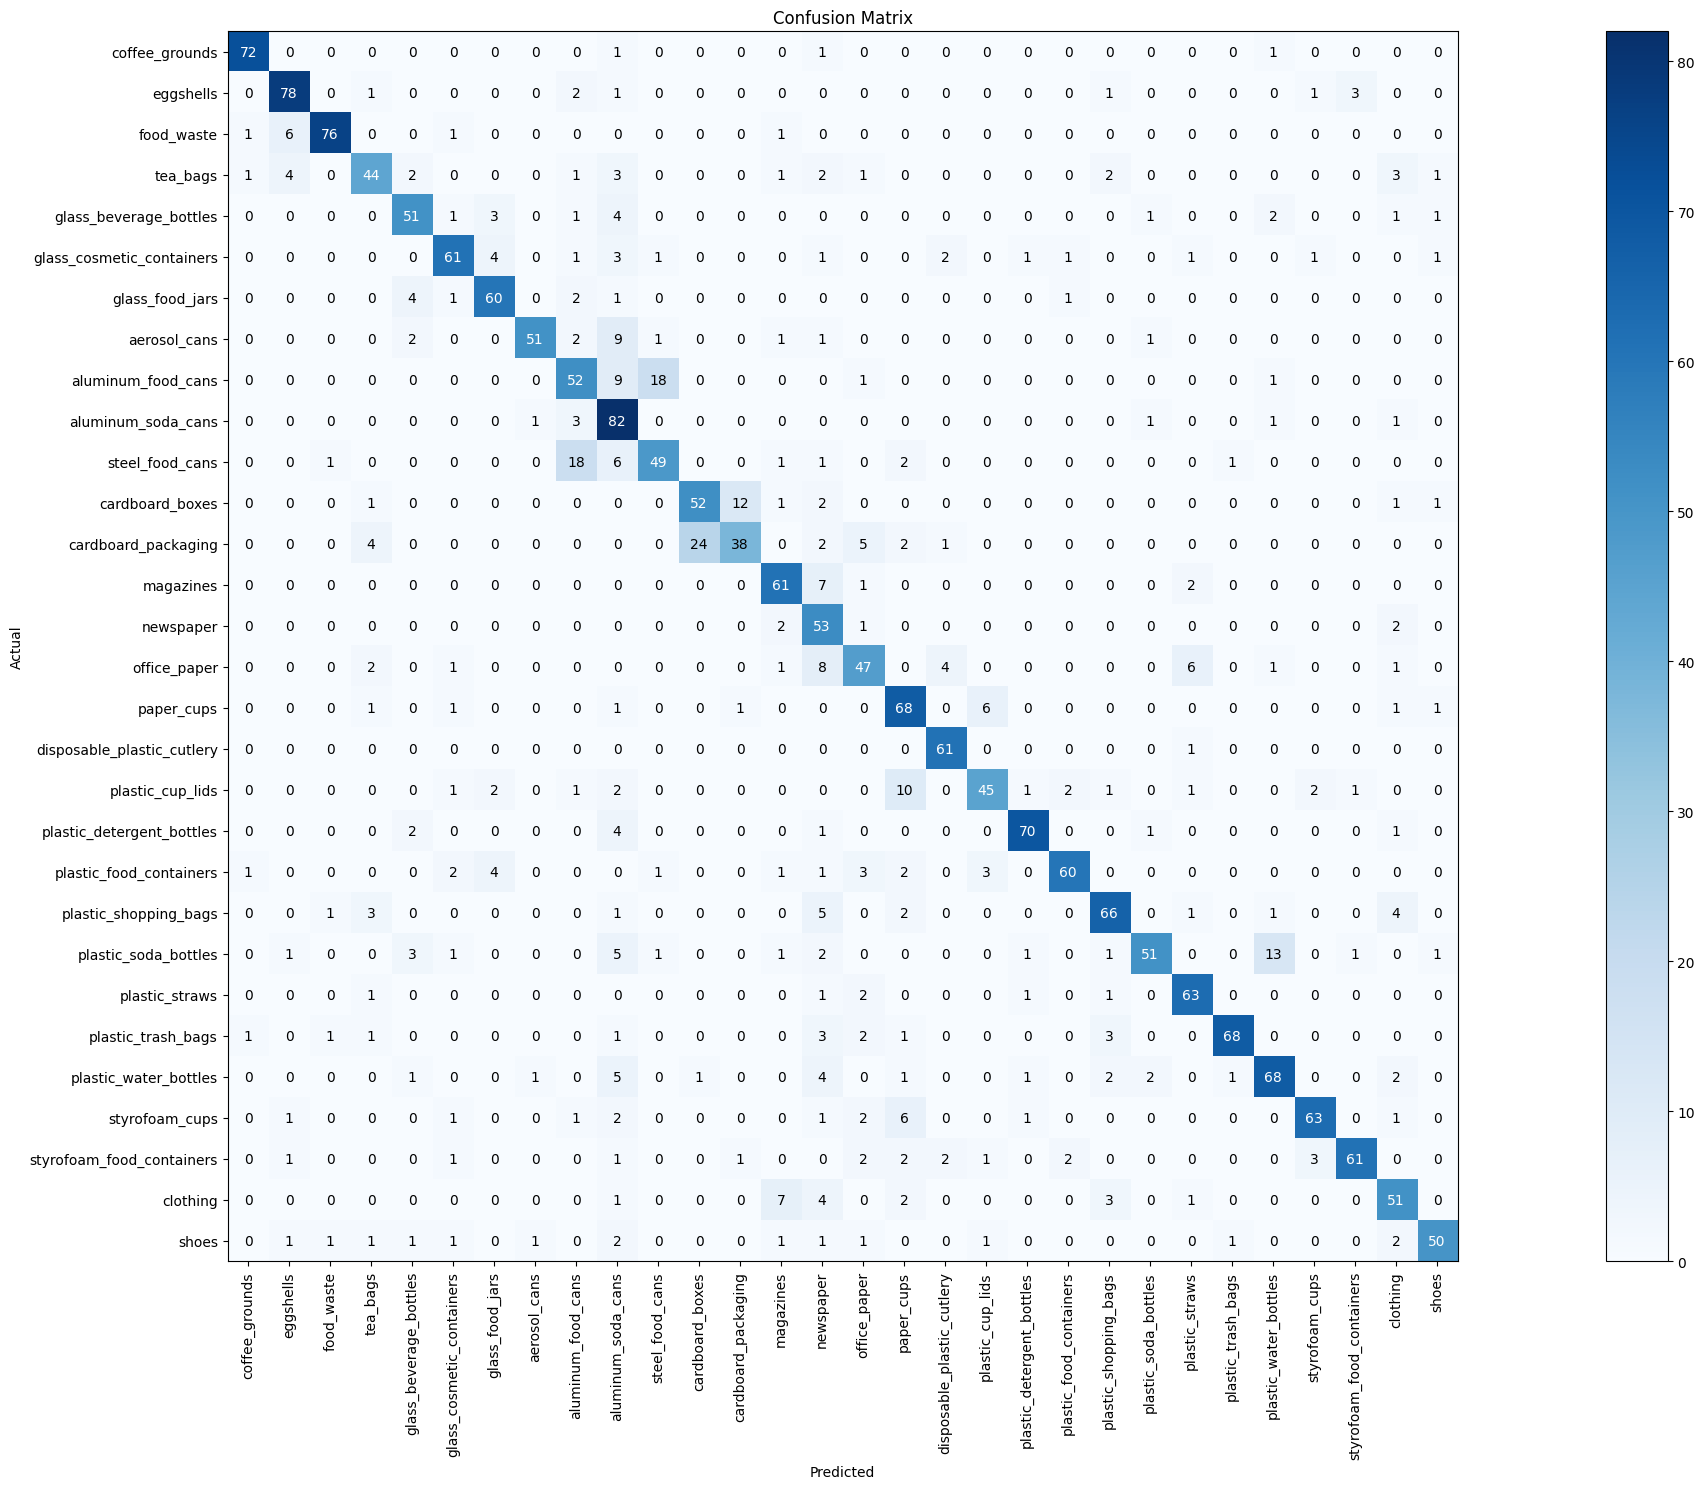


Classification Report:
               precision    recall  f1-score   support

   Foodwaste       0.93      0.89      0.91       312
       Glass       0.88      0.88      0.88       212
       Metal       0.85      0.95      0.90       317
      Papers       0.79      0.90      0.84       426
     Plastic       0.93      0.84      0.89       849
     Textile       0.83      0.79      0.81       134

    accuracy                           0.88      2250
   macro avg       0.87      0.88      0.87      2250
weighted avg       0.88      0.88      0.88      2250



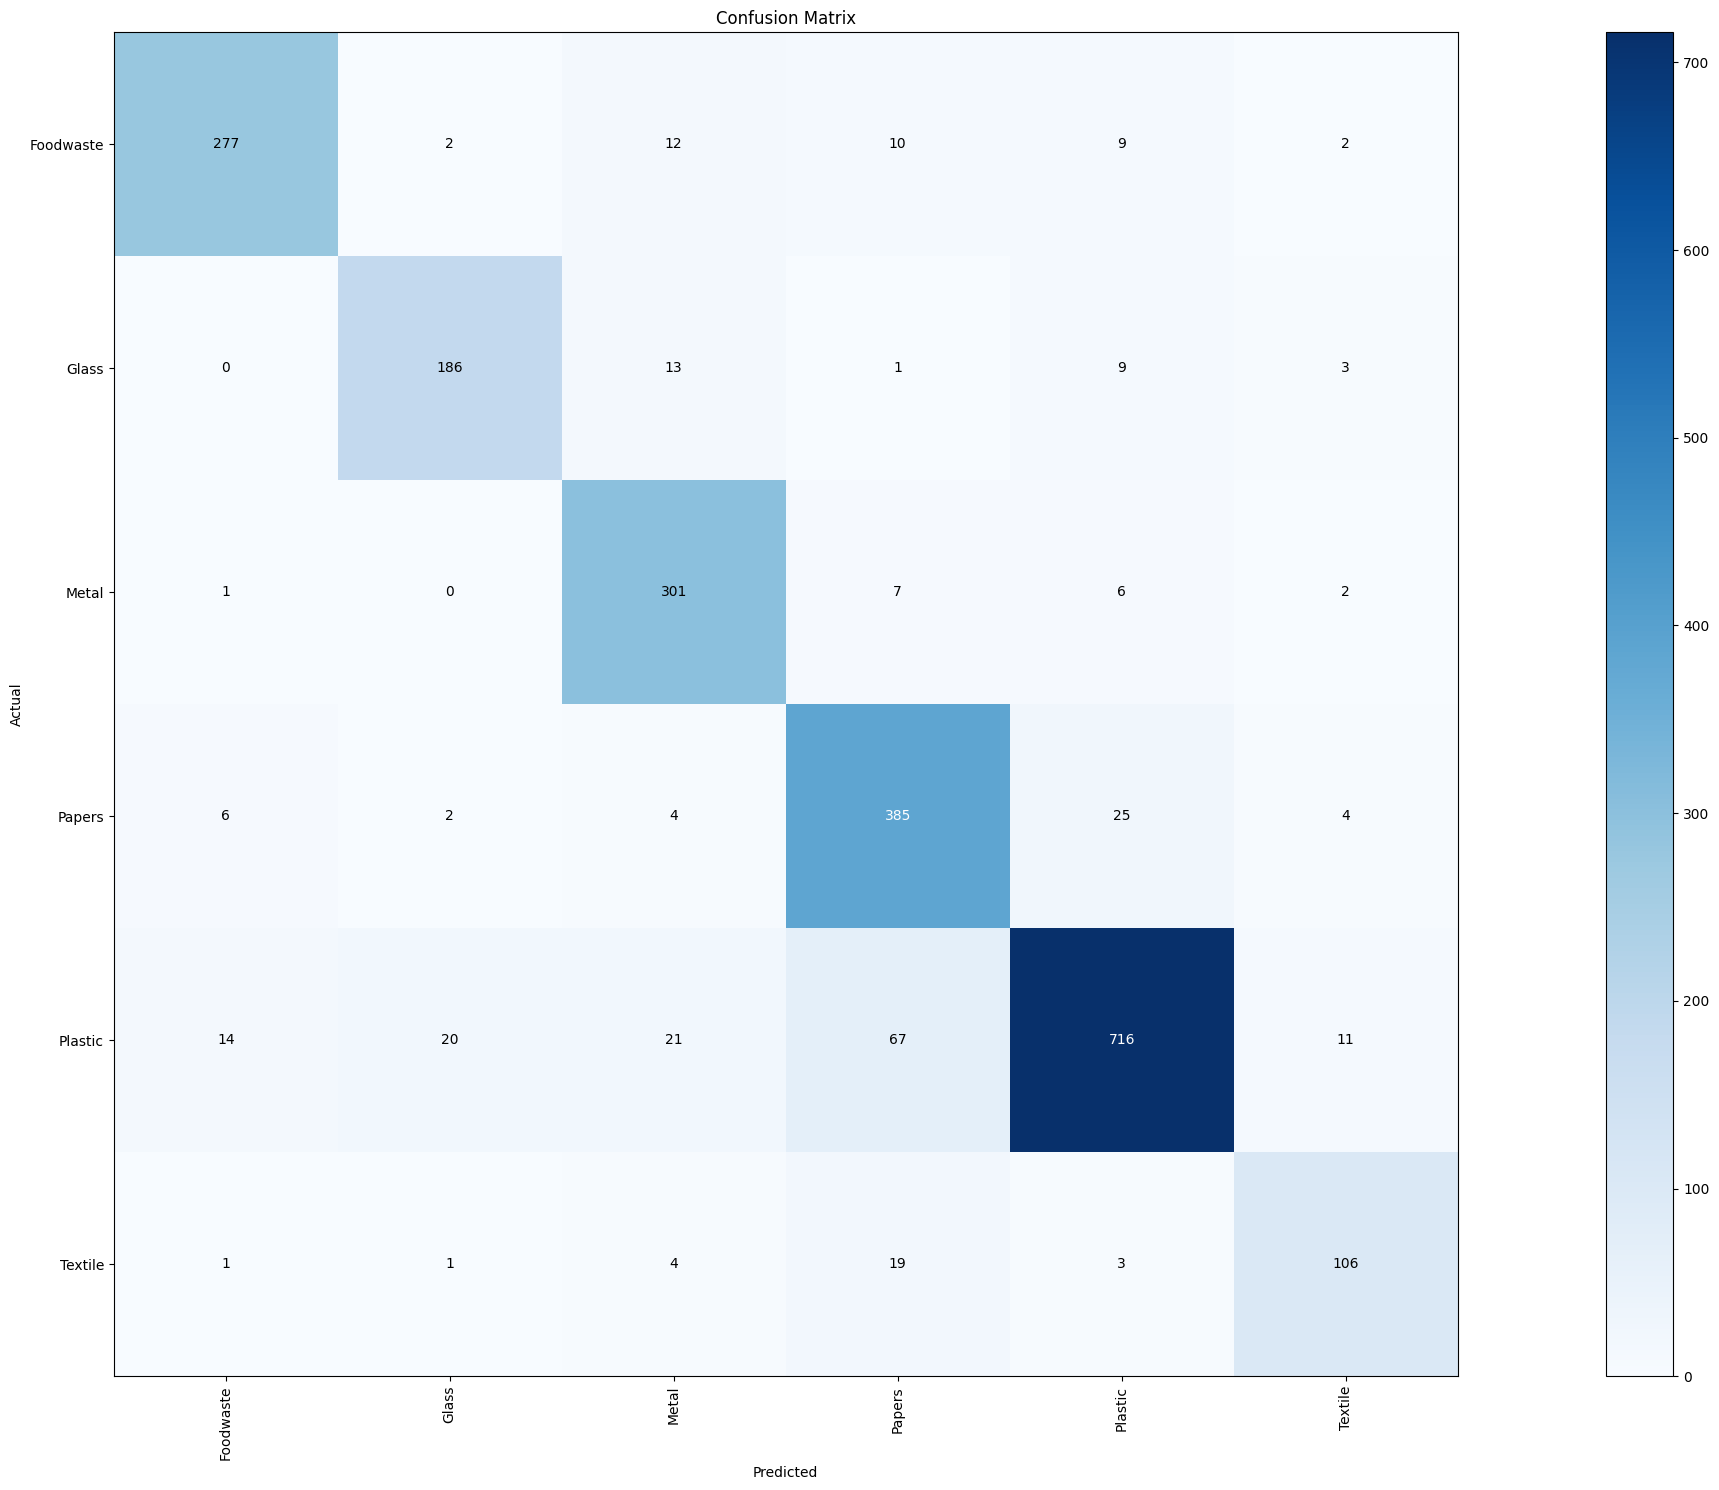

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_wastes = []
all_wastes_pred = []
all_categories = []
all_categories_pred = []
model = multitaskmodel2.to(device)

model.eval()

with torch.no_grad():
    for images, wastes, categories in test_loader:
        images = images.to(device)
        wastes = wastes.to(device)
        categories = categories.to(device)

    
        out_waste, out_category = model(images)
        _, waste_pred = torch.max(out_waste, 1)
        _, category_pred = torch.max(out_category, 1)

        all_wastes.extend(wastes.cpu().numpy())
        all_wastes_pred.extend(waste_pred.cpu().numpy())
        all_categories.extend(categories.cpu().numpy())
        all_categories_pred.extend(category_pred.cpu().numpy())

conf_matrix = confusion_matrix(all_wastes, all_wastes_pred, labels=list(range(30)))

all_wastes = np.array(all_wastes, dtype=int)
all_wastes_pred = np.array(all_wastes_pred, dtype=int)
all_categories = np.array(all_categories, dtype=int)
all_categories_pred = np.array(all_categories_pred, dtype=int)

evaluate_task(all_wastes, all_wastes_pred, target_names=list(label_map.keys()), labels=list(range(30)))
evaluate_task(all_categories, all_categories_pred, target_names=['Foodwaste', 'Glass', 'Metal', 'Papers', 'Plastic', 'Textile'], labels=list(range(6)))